In [ ]:
import collections
from dataclasses import dataclass
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import re
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from typing import Optional, Tuple
import zipfile

# Download the Raw Data

In [2]:
dataset_zip_url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
data_dir = "data/"

In [3]:
# Download the dataset file and unzip it, saving it to the `data/` directory.
response = requests.get(dataset_zip_url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall(data_dir)

# EDA
We will perform some light Exploratory Data Analysis (EDA) to get a better feel for our data. Some of our takeaways:

- Most of the labels are "ham". This seems intiutive since most SMS messages are legitimate.
- Most of the messages are short. The average length is only 15 words.
- The average length of a spam message is 23 words and the average length of a ham message is 15 words.
- Spam messages tend to be longer than ham messages.
- Some of the most popular spam words are "call" and "free" implying spam messages involve talking to someone and/or winning something for free. This seems intuitive because spammers need a way to entice people.
- The most popular words in “ham” messages seem to be more personal such as "I", "you", "u", "me", and "my".

In [4]:
# Load the dataset.
dataset_path = pathlib.Path(data_dir) / "SMSSpamCollection"
df = pd.read_csv(dataset_path, sep="\t", header=None, names=["label", "text"])

In [5]:
# Check out the first 5 rows.
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


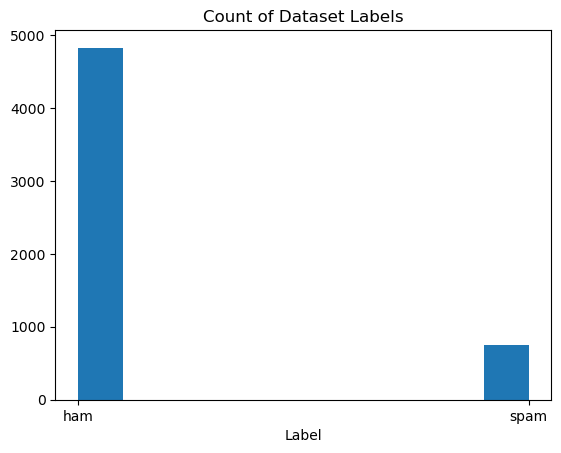

In [6]:
# Let's see how balanced the dataset is.
# That is, let's see how many "ham" labels there are compared to "spam" labels.
plt.hist(df["label"])
plt.title("Count of Dataset Labels")
plt.xlabel("Label")
plt.show()

In [7]:
label_freq = df["label"].value_counts(normalize=True) * 100
ham_freq = round(label_freq["ham"], 0)
print(f"{ham_freq}% of the labels are 'ham'.")

87.0% of the labels are 'ham'.


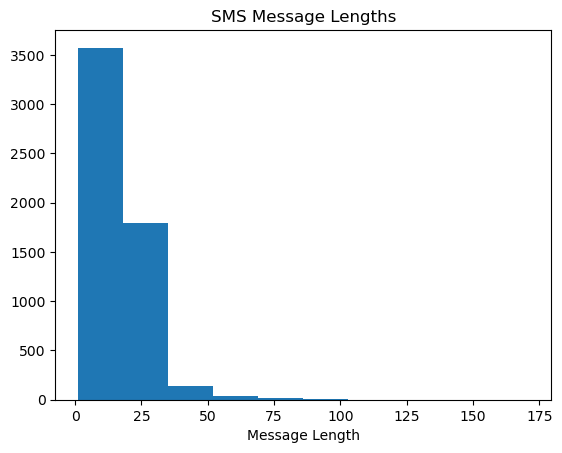

In [8]:
# Let's see how long messages are.
df.loc[:, "message_length"] = df["text"].apply(lambda t: len(t.split())) # Split by whitespace to get a rough estimate.

plt.hist(df["message_length"])
plt.title("SMS Message Lengths")
plt.xlabel("Message Length")
plt.show()

In [9]:
avg_message_len = int(df["message_length"].mean())
print(f"The average message length is", avg_message_len, "words.")

The average message length is 15 words.


In [10]:
avg_spam_message_len = int(df.loc[df["label"] == "spam", "message_length"].mean())
print(f"The average spam message length is", avg_spam_message_len, "words.")

The average spam message length is 23 words.


In [11]:
avg_ham_message_len = int(df.loc[df["label"] == "ham", "message_length"].mean())
print(f"The average spam message length is", avg_ham_message_len, "words.")

The average spam message length is 14 words.


In [12]:
def get_word_freq(text: str) -> collections.Counter:
    """Get word frequency from the given text.

    Parameters
    ----------
    text : str
        The given text.

    Returns
    -------
    collections.Counter
        The word counts.
    """

    text = text.lower()
    split_text = re.split("\W", text) # Split the text by any non-word character.
    word_pattern = re.compile("\w")
    words = [word for word in split_text if word_pattern.match(word)] # Only grab words.
    return collections.Counter(words)

In [13]:
# Let's check out the top 10 words used in spam messages.
top_n_words = 10
spam_message_top_ten_word_count = get_word_freq(" ".join(df.loc[df["label"] == "spam", "text"].values)).most_common(top_n_words)
spam_message_top_ten_word_count

[('to', 691),
 ('a', 380),
 ('call', 355),
 ('you', 297),
 ('your', 264),
 ('free', 224),
 ('2', 207),
 ('the', 206),
 ('for', 204),
 ('now', 199)]

In [14]:
# Let's check out the top words used in ham messages.
ham_message_top_ten_word_count = get_word_freq(" ".join(df.loc[df["label"] == "ham", "text"].values)).most_common(top_n_words)
ham_message_top_ten_word_count

[('i', 2960),
 ('you', 1948),
 ('to', 1562),
 ('the', 1133),
 ('a', 1070),
 ('u', 1033),
 ('and', 858),
 ('in', 823),
 ('me', 777),
 ('my', 754)]

# Preprocess the Data

In [15]:
# Generate our configuration
@dataclass
class Config:
    min_df: int = 5 # Ignore words that have occurred less than `min_df` times.
    ngram_range: Tuple = (1, 2) # Extract unigrams and bigrams.
    stop_words: Optional[str] = None # What set of stop words to use.
    train_split_pct: float = 0.7 # What percentage of the dataset will be used for training.
    seed: int = 21 # For reproducibility

    def __post_init__(self):
        # Ensure `train_split_pct` is at least 10% and no more than 99%.
        if self.train_split_pct < 0.1 or self.train_split_pct > 0.99:
            raise ValueError("train_split_pct must be in the range (0.1, 0.99)")

In [17]:
config = Config()

In [18]:
# Split data into train and test sets. Use stratification to keep an even balance of labels.
X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=config.train_split_pct,
    stratify=y,
    random_state=config.seed,
)

In [19]:
# Both the train and test sets have about 86% of their labels classified as "ham".
y_train.value_counts(), y_test.value_counts()

(label
 ham     3377
 spam     523
 Name: count, dtype: int64,
 label
 ham     1448
 spam     224
 Name: count, dtype: int64)

# Train the Model

In [20]:
vectorizer = TfidfVectorizer(
    min_df=config.min_df,
    ngram_range=config.ngram_range,
    stop_words=config.stop_words,
)
log_reg = LogisticRegression(random_state=config.seed)
pipeline = Pipeline(
    [
        ("vectorizer", vectorizer),
        ("classifier", log_reg),
    ]
)

In [21]:
# Calculating TF-IDF on entire corpus will result in data leakage because the vectorizer will contain information
# about the test set.
# Calculating TF-IDF on the training and test set separately will potentially result in poor performance on the test
# set because it's small.
# Therefore, we can train the TF-IDF vectorizer on just the training data then use that vectorizer to calculate the
# features for both the training and test set.
model = pipeline.fit(X_train, y_train)

# Evaluate the Model

In [22]:
y_pred = model.predict(X_test)

In [23]:
labels = model.classes_
# "ham" is designated as the positive class.
# "spam" is designated as the negative class.
labels

array(['ham', 'spam'], dtype=object)

In [24]:
# For each class in this report (i.e. "ham" and "spam") the metrics are calculated as if there were only two classes, 
# "X" and "not X".
# e.g. For "spam", the metrics are calculated for binary classification of "spam". That is, "spam" and "not spam".
print("Classification report:")
print()
print(classification_report(y_test, y_pred, labels=labels))

Classification report:

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1448
        spam       0.99      0.77      0.87       224

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.92      1672
weighted avg       0.97      0.97      0.97      1672


In [25]:
cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=labels), 
    index=labels, 
    columns=labels,
)
# The sklearn confusion matrix is read like so:
#
#                   Model Predictions
#                ---------------------
#               |       ham   spam
# Actual Values | ham   1446     2
#               | spam    51   173
#
print("Confusion matrix:")
print()
print(cm_df)

Confusion matrix:

       ham  spam
ham   1446     2
spam    51   173


## Check out Some of the Model's Mispredictions Manually
Let's check out some of the SMS messages where the model predicted "ham", but it was "spam". We want to
identify as many actual spam messages as spam so we can block them from reaching the user.

Some of our takeaways:
- The sampled messages look pretty fishy and don't look mislabeled. We could improve our model.
- If we built out an application to block spam SMS messages, our model would have let 51 spam messages through from our test set. We should minimize this as much as possible.

In [37]:
# Sample first 5 messages
samples_idx = list(range(5))
bad_preds = X_test[(y_pred == "ham") & (y_test == "spam")]
# print(bad_preds.shape) # 51 bad predictions matches our confusion matrix above
messages = bad_preds.iloc[samples_idx]
for message in messages:
    print(message)
    print("=" * 50)

network operator. The service is free. For T & C's visit 80488.biz
1000's of girls many local 2 u who r virgins 2 this & r ready 2 4fil ur every sexual need. Can u 4fil theirs? text CUTE to 69911(£1.50p. m)
Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner
Fantasy Football is back on your TV. Go to Sky Gamestar on Sky Active and play £250k Dream Team. Scoring starts on Saturday, so register now!SKY OPT OUT to 88088
Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
